# Задание:
1. Загрузить датасет WINE.
2. Подготовить выборки: обучающую 70% и тестовую 30% - для воспроизводимости результатов использовать random_state=123.
3. Построить сеть с минимальным числом нейронов в скрытых слоях обеспечивающую наибольшее значение метрики accuracy =1 для датасета WINE.
Входное число нейронов равно количеству признаков (13). Оценку качества проводить по тестовой выборке.
4. Описание сети (результат вызова Summary()) и оценку качества классификации записать в текстовое поле.
5. В качестве ответа разместить .ipynb файл и файл с модели нейронной сети .keras.

Ваша оценка за работу будет зависеть от достигнутого минимума нейронов в сети.

In [1]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_wine
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import homogeneity_score, completeness_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors

In [2]:
wine_data = load_wine()
X = pd.DataFrame(wine_data.data, columns=wine_data.feature_names)
y = wine_data.target

In [3]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [ ]:
kmeans = KMeans(n_clusters=3, init='k-means++', random_state=42)
kmeans_labels = kmeans.fit_predict(X_scaled)

kmeans_homogeneity = homogeneity_score(y, kmeans_labels)
kmeans_completeness = completeness_score(y, kmeans_labels)

print("KMeans++ Results:")
print(f"Homogeneity: {kmeans_homogeneity:.4f}")
print(f"Completeness: {kmeans_completeness:.4f}")

KMeans++ Results:
Homogeneity: 0.8788
Completeness: 0.8730


In [ ]:
best_completeness_agg = 0
best_params_agg = {}
for linkage in ["ward", "complete", "average", "single"]:
    for n_clusters in range(2, 10):
        agg_cluster = AgglomerativeClustering(n_clusters=n_clusters, linkage=linkage)
        agg_labels = agg_cluster.fit_predict(X_scaled)
        completeness = completeness_score(y, agg_labels)
        if completeness > best_completeness_agg:
            best_completeness_agg = completeness
            best_params_agg = {"n_clusters": n_clusters, "linkage": linkage}

agg_cluster = AgglomerativeClustering(**best_params_agg)
agg_labels = agg_cluster.fit_predict(X_scaled)

print("\nAgglomerativeClustering Best Results:")
print(f"Best Params: {best_params_agg}")
print(f"Completeness: {best_completeness_agg:.4f}")


AgglomerativeClustering Best Results:
Best Params: {'n_clusters': 3, 'linkage': 'ward'}
Completeness: 0.7825


In [ ]:
best_completeness_dbscan = 0
best_params_dbscan = {}
for eps in np.arange(0.1, 2.0, 0.1):
    for min_samples in range(2, 10):
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        dbscan_labels = dbscan.fit_predict(X_scaled)
        # Ignore noise points (-1) for scoring
        if len(set(dbscan_labels)) > 1:
            completeness = completeness_score(y, dbscan_labels)
            if completeness > best_completeness_dbscan:
                best_completeness_dbscan = completeness
                best_params_dbscan = {"eps": eps, "min_samples": min_samples}

if best_params_dbscan:
    dbscan = DBSCAN(**best_params_dbscan)
    dbscan_labels = dbscan.fit_predict(X_scaled)
else:
    dbscan_labels = np.full_like(y, -1)

print("\nDBSCAN Best Results:")
print(f"Best Params: {best_params_dbscan}")
print(f"Completeness: {best_completeness_dbscan:.4f}")


DBSCAN Best Results:
Best Params: {'eps': np.float64(1.9000000000000001), 'min_samples': 7}
Completeness: 0.4747


In [ ]:
from sklearn.metrics import silhouette_score

algorithms = {
    "KMeans": kmeans_labels,
    "Agglomerative": agg_labels,
    "DBSCAN": dbscan_labels,
}

for name, labels in algorithms.items():
    if len(set(labels)) > 1:  # Silhouette score is undefined for one cluster
        score = silhouette_score(X_scaled, labels)
        print(f"{name} Silhouette Score: {score:.4f}")
    else:
        print(f"{name} Silhouette Score: Not applicable (only one cluster or all noise)")

KMeans Silhouette Score: 0.2849
Agglomerative Silhouette Score: 0.2774
DBSCAN Silhouette Score: -0.0345


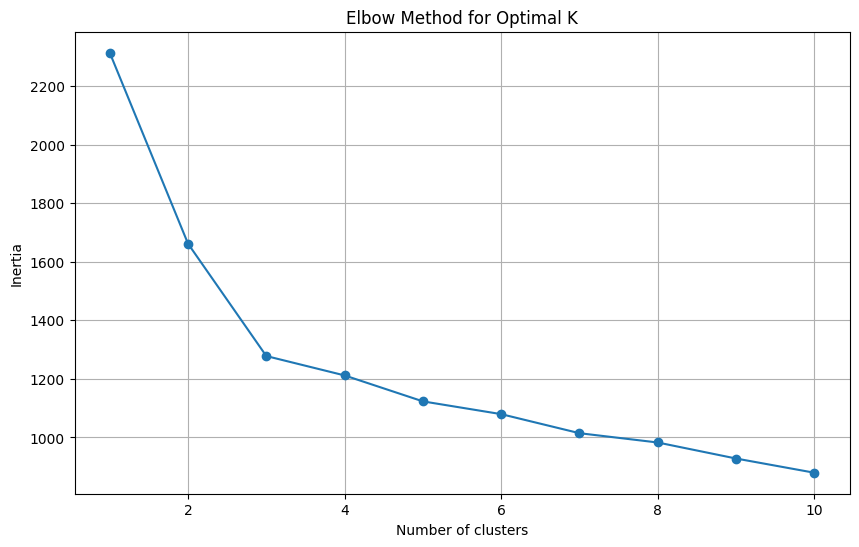

Clustering Results Summary:

KMeans++ Homogeneity: 0.8788

KMeans++ Completeness: 0.8730

Agglomerative Best Completeness: 0.7825 with {'n_clusters': 3, 'linkage': 'ward'}

DBSCAN Best Completeness: 0.4747 with {'eps': np.float64(1.9000000000000001), 'min_samples': 7}



In [ ]:
inertia_values = []
cluster_range = range(1, 11)

for n_clusters in cluster_range:
    kmeans = KMeans(n_clusters=n_clusters, init='k-means++', random_state=42)
    kmeans.fit(X_scaled)
    inertia_values.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(cluster_range, inertia_values, marker='o')
plt.title("Elbow Method for Optimal K")
plt.xlabel("Number of clusters")
plt.ylabel("Inertia")
plt.grid()
plt.show()

print("Clustering Results Summary:\n")
print(f"KMeans++ Homogeneity: {kmeans_homogeneity:.4f}\n")
print(f"KMeans++ Completeness: {kmeans_completeness:.4f}\n")
print(f"Agglomerative Best Completeness: {best_completeness_agg:.4f} with {best_params_agg}\n")
print(f"DBSCAN Best Completeness: {best_completeness_dbscan:.4f} with {best_params_dbscan}\n")

